In [1]:
from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR

In [2]:
all_df = pd.read_excel('data_dict_df.xlsx')
all_df['diff'] = all_df.non_proc_timestamps-all_df.timestamps # this is what we'll predict

runs = all_df.uuid.unique().tolist()

for run in runs:
    sub_df = all_df[all_df.uuid==run]
    
    # re-reference timestamps
    sub_df.timestamps -= sub_df.timestamps.iloc[0]
    sub_df.non_proc_timestamps -= sub_df.non_proc_timestamps.iloc[0]
    
    all_df.loc[all_df.uuid==run, 'timestamps'] = sub_df.timestamps
    all_df.loc[all_df.uuid==run, 'non_proc_timestamps'] = sub_df.non_proc_timestamps

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Windowed approach to predict offset from trial_duration

In [3]:
all_windows_subs = []
for r in runs:
    sub_df = all_df[all_df.uuid==r]
    sub_df['processed_trial_duration_1'] = sub_df.processed_trial_duration.shift(1)
    sub_df['processed_trial_duration_2'] = sub_df.processed_trial_duration.shift(2)
    sub_df['processed_trial_duration_m1'] = sub_df.processed_trial_duration.shift(-1)
    sub_df['processed_trial_duration_m2'] = sub_df.processed_trial_duration.shift(-2)
    sub_df['adjusted_timestamp'] = sub_df.non_proc_timestamps.shift(1).add(sub_df.processed_trial_duration, fill_value=0)
    all_windows_subs.append(sub_df)
all_windows_subs = pd.concat(all_windows_subs)
all_windows_subs['adjusted_diff'] = all_windows_subs['adjusted_timestamp'] - all_windows_subs['timestamps']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

## Plots (the problem and goal)

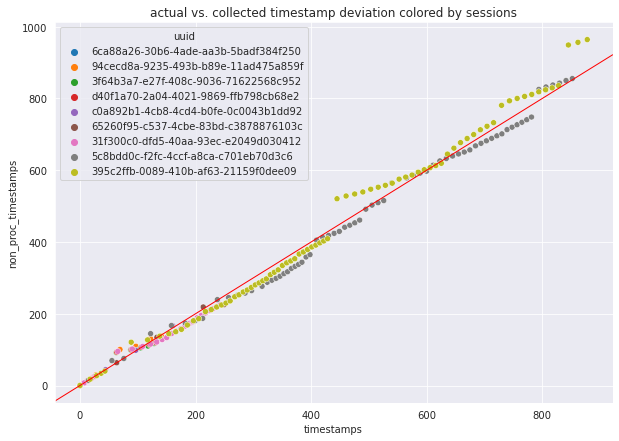

In [11]:
fig, axs = plt.subplots(figsize=(10,7))
sns.scatterplot(data=all_windows_subs, y="non_proc_timestamps", x="timestamps",legend=True, ax=axs, hue='uuid')
axs.set_title('actual vs. collected timestamp deviation colored by sessions')
axs.axline((0, 0), (1, 1), linewidth=1, color='r')

In [224]:
import ast

ast.literal_eval('[333 232 2323]')

SyntaxError: invalid syntax (<unknown>, line 1)

(0.0, 200.0)

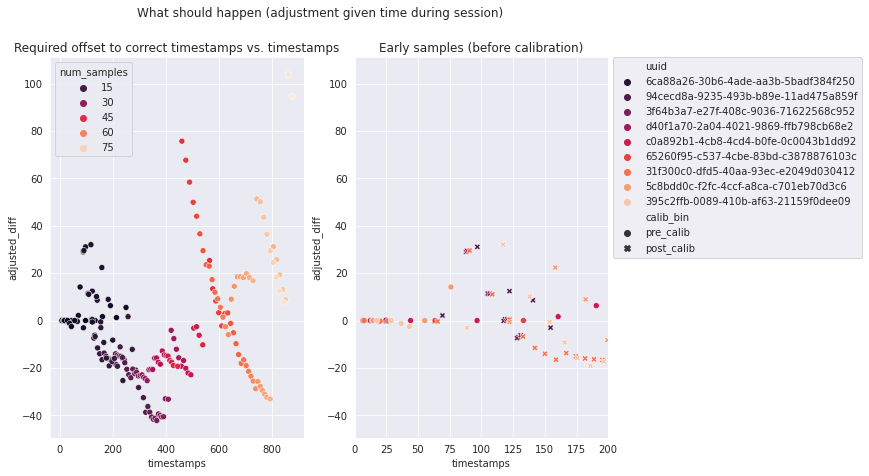

In [223]:
calib_cut_df = all_windows_subs
calib_cut_df['calib_bin'] = "post_calib"
calib_cut_df.loc[calib_cut_df.num_samples <= 5, 'calib_bin'] = "pre_calib"

fig, axs = plt.subplots(1,2,figsize=(10,7))
sns.scatterplot(data=all_windows_subs, x="timestamps", y="adjusted_diff",legend=True, hue='num_samples', palette="rocket", ax=axs[0])
sns.scatterplot(data=calib_cut_df, x="timestamps", y="adjusted_diff",legend=True, hue='uuid', style='calib_bin', palette="rocket", ax=axs[1])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

fig.suptitle('What should happen (adjustment given time during session)')
axs[0].set_title('Required offset to correct timestamps vs. timestamps')
axs[1].set_title('Early samples (before calibration)')
axs[1].set_xlim(0, 200)
#axs[1].set_ylim(-15, 15)
#axs.legend(['predicted_offset','adjusted_offset'])

Root Mean squared error: 6.71
Coefficient of determination: 0.87
RMSE timestamp seconds 14.51137794265054


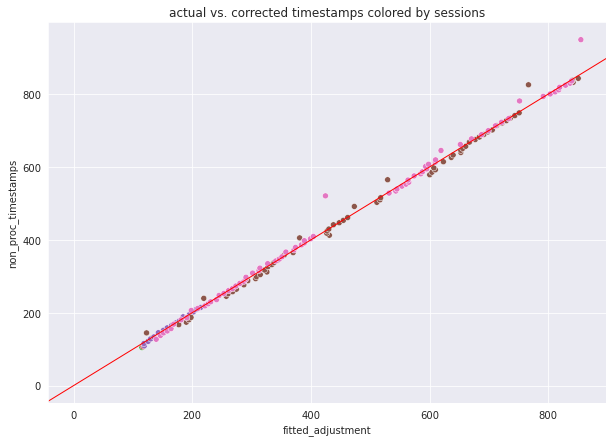

In [191]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def plot_fitted(regr, na_dropped, features):
    fig, axs = plt.subplots(figsize=(10,7))
    pred_offsets = regr.predict(na_dropped[features])
    na_dropped['fitted_adjustment'] = na_dropped.timestamps + pred_offsets
    sns.scatterplot(data=na_dropped,  y="non_proc_timestamps", x="fitted_adjustment", hue="uuid",legend=None, ax=axs)
    axs.axline((0, 0), (1, 1), linewidth=1, color='r')
    axs.set_title('actual vs. corrected timestamps colored by sessions')
    #axs.set_xlim(0,200)
    #axs.set_ylim(0,200)
    print('RMSE timestamp seconds', np.sqrt(np.mean((na_dropped.fitted_adjustment-na_dropped.non_proc_timestamps)**2)))
    return pred_offsets

all_windows_subs_nonna = all_windows_subs.loc[['adjusted_diff', 'non_proc_timestamps', 'non_proc_trial_duration', 'uuid', 'uuid_trial', 'timestamps', 'processed_trial_duration', 'processed_trial_duration_1', 'processed_trial_duration_2', 'processed_trial_duration_m1', 'processed_trial_duration_m2']].copy().dropna()

# features = ['processed_trial_duration',  'processed_trial_duration_1', 'processed_trial_duration_2', 'processed_trial_duration_m1', 'processed_trial_duration_m2']
features = ['processed_trial_duration',  'processed_trial_duration_1', 'timestamps']
y_var = 'adjusted_diff'
# y_var = 'non_proc_trial_duration' # does not work as well
rel_x = all_windows_subs_nonna[features] # does not work as well
X_train, X_test, y_train, y_test = train_test_split(rel_x, all_windows_subs_nonna[y_var], test_size=0.33)

# Train the model using the training sets
regr = RandomForestRegressor()
# regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
# print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Root Mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

pred_offsets = plot_fitted(regr, all_windows_subs_nonna, features)
all_windows_subs_nonna['predicted_offset'] = pred_offsets
all_windows_subs_nonna['recalculated_trial_durations'] = all_windows_subs_nonna.fitted_adjustment.diff()


## Plots

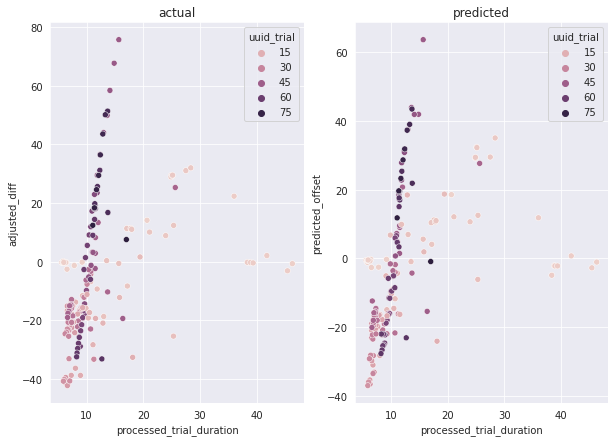

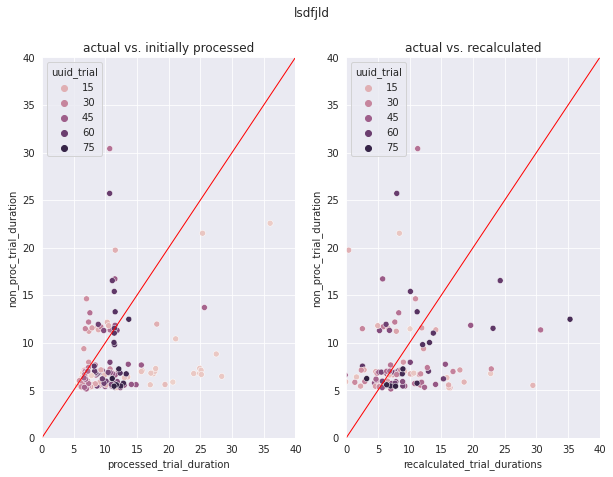

In [8]:

fig, axs = plt.subplots(1,2,figsize=(10,7))
sns.scatterplot(data=all_windows_subs_nonna, x="processed_trial_duration", y="adjusted_diff",legend=True, ax=axs[0], hue='uuid_trial')
sns.scatterplot(data=all_windows_subs_nonna, x="processed_trial_duration", y="predicted_offset",legend=True, ax=axs[1], hue='uuid_trial')

axs[0].set_title('actual')
axs[1].set_title('predicted')

fig, axs = plt.subplots(1,2,figsize=(10,7))
sns.scatterplot(data=all_windows_subs_nonna, x="processed_trial_duration", y="non_proc_trial_duration",legend=True, ax=axs[0], hue='uuid_trial')
sns.scatterplot(data=all_windows_subs_nonna, x="recalculated_trial_durations", y="non_proc_trial_duration",legend=True, ax=axs[1], hue='uuid_trial')
fig.suptitle('lsdfjld')
axs[0].set_title('actual vs. initially processed')
axs[1].set_title('actual vs. recalculated')

axs[0].set_xlim(0,40)
axs[1].set_xlim(0,40)
axs[0].set_ylim(0,40)
axs[1].set_ylim(0,40)

axs[0].axline((0, 0), (1, 1), linewidth=1, color='r')
axs[1].axline((0, 0), (1, 1), linewidth=1, color='r')
#axs.set_ylim(0,25)
#axs.legend(['predicted_offset','adjusted_offset'])

# Using Statsmodels OLS

In [511]:
tdur_model = ols("adjusted_diff ~ processed_trial_duration + processed_trial_duration_1", data=all_windows_subs).fit()

# summarize our model
tdur_model_summary = tdur_model.summary()

# convert our table to HTML and add colors to headers for explanatory purposes
HTML(
(tdur_model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)


# Misc

In [150]:
def get_x_y(df):
    merged_dfs = []
    for r in df.uuid.unique():
        data = df[df.uuid==r]
        data = df[['real-collected_time_diff', 'processed_trial_duration']]
        # data['2-back-diff'] = data['real-collected_time_diff'].shift(2)
        # data['1-back-diff'] = data['real-collected_time_diff'].shift(1)
        data['1-back-tdur'] = data['processed_trial_duration'].shift(1)
        data['1-forward-tdur'] = data['processed_trial_duration'].shift(-1)
        data['next-time_diff'] = data['real-collected_time_diff'].shift(-1)
        # data['2-back-tdur'] = data['processed_trial_duration'].shift(2)
        data = data.dropna()
        merged_dfs.append(data)
    merged_dfs = pd.concat(merged_dfs)
    y = data['next-time_diff']
    #X = data[['processed_trial_duration','1-back-tdur', '1-forward-tdur']]
    X = data[['processed_trial_duration','1-back-tdur', '1-forward-tdur']]
    # X = data[['processed_trial_duration','1-back-tdur','2-back-tdur']]
    return X,y

def get_x_y_with_diff(df):
    merged_dfs = []
    for r in df.uuid.unique():
        data = df[df.uuid==r]
        data = df[['real-collected_time_diff', 'processed_trial_duration']]
        # data['2-back-diff'] = data['real-collected_time_diff'].shift(2)
        data['1-back-diff'] = data['real-collected_time_diff'].shift(1)
        data['1-back-tdur'] = data['processed_trial_duration'].shift(1)
        data['1-forward-tdur'] = data['processed_trial_duration'].shift(-1)
        data['next-time_diff'] = data['real-collected_time_diff'].shift(-1)
        # data['2-back-tdur'] = data['processed_trial_duration'].shift(2)
        data = data.dropna()
        merged_dfs.append(data)
    merged_dfs = pd.concat(merged_dfs)
    y = data['next-time_diff']
    #X = data[['processed_trial_duration','1-back-tdur', '1-forward-tdur']]
    X = data[['processed_trial_duration','1-back-tdur', '1-forward-tdur', '1-back-diff']]
    # X = data[['processed_trial_duration','1-back-tdur','2-back-tdur']]
    return X,y

def get_x_y_predict_bare(uuid, model):
    df = all_df[all_df.uuid == uuid]
    data = df.copy().reset_index(drop=True)
    data['1-back-tdur'] = data['processed_trial_duration'].shift(1)
    data['1-forward-tdur'] = data['processed_trial_duration'].shift(-1)
    next_timestamp = None
    next_trial_duration = None
    for index, row in data.iterrows():
        if index > 1 and index < len(data):
            if index > 2:
                row['timestamps'] = next_timestamp
                row['processed_trial_duration'] = data.at[index, 'timestamps'] - data.at[index-1, 'timestamps']
            
                # change the underlying dataframe too
                data.loc[index, 'timestamps'] = row['timestamps']
                data.loc[index+1, 'processed_trial_duration'] = row['processed_trial_duration']
            row['processed_trial_duration'] = data.loc[index, 'timestamps'] - data.loc[index-1, 'timestamps']
            row['1-back-tdur'] = data.loc[index-1, 'timestamps'] - data.loc[index-2, 'timestamps']
            row['1-forward-tdur'] = data.loc[index+1, 'timestamps'] - data.loc[index, 'timestamps']
            row_df = pd.DataFrame(row[['processed_trial_duration','1-back-tdur', '1-forward-tdur']]).T
            next_time_diff = model.predict(row_df).values[0]
            # reset the next timestamps and compute duration
            next_timestamp = data.at[index+1, 'timestamps'] + next_time_diff
            next_trial_duration = next_timestamp - data.at[index, 'timestamps']
            print('next_time_diff',next_time_diff,'next_timestamp',next_timestamp,'next_trial_duration',next_trial_duration)
    return data

def get_x_y_predict(uuid, model):
    df = all_df[all_df.uuid == uuid]
    data = df.copy().reset_index(drop=True)
    data['1-back-diff'] = np.NaN
    data.iloc[:3]['1-back-diff'] = 4e-6
    data['1-back-tdur'] = data['processed_trial_duration'].shift(1)
    data['1-forward-tdur'] = data['processed_trial_duration'].shift(-1)
    next_timestamp = None
    next_trial_duration = None
    next_back_diff = None
    for index, row in data.iterrows():
        if index > 1 and index < len(data)-1:
            old_timestamp = data.loc[index, 'timestamps']
            if index > 2: 
                row['timestamps'] = next_timestamp
                row['processed_trial_duration'] = next_trial_duration
                row['1-back-diff'] = next_time_diff
                
                # change the underlying dataframe too
                data.loc[index, 'timestamps'] = next_timestamp
                data.loc[index, 'processed_trial_duration'] = next_trial_duration
                data.loc[index, '1-back-diff'] = next_time_diff
                
                row['1-back-tdur'] = data.loc[index-1, 'timestamps'] - data.loc[index-2, 'timestamps']
                row['1-forward-tdur'] = data.loc[index+1, 'timestamps'] - data.loc[index, 'timestamps']
                
            row_df = pd.DataFrame(row[['processed_trial_duration','1-back-tdur', '1-forward-tdur', '1-back-diff']]).T
            next_time_diff = model.predict(row_df).values[0]
            # reset the next timestamps and compute duration
            next_timestamp = data.at[index+1, 'timestamps'] + next_time_diff
            next_trial_duration = next_timestamp - data.at[index, 'timestamps']
    return data


## Fit

In [146]:
# df = all_df[all_df.uuid == '31f300c0-dfd5-40aa-93ec-e2049d030412']
X,y = get_x_y(all_df)
model = sm.OLS(y,X).fit()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

## Predict

In [204]:
def get_x_y(df, model):
    all_dfs = []
    for r in df.uuid.unique():
        data = df[df.uuid==r]
        data['1-back-tdur'] = data['processed_trial_duration'].shift(1)
        data['1-forward-tdur'] = data['processed_trial_duration'].shift(-1)
        data_full = data[['processed_trial_duration', '1-back-tdur', '1-forward-tdur']]
        mask = data_full.notna().all(axis=1)
        data_full = data_full.dropna()
        time_diff_predictions = model.predict(data_full)
        data['ts_adjust'] = np.NaN
        data.loc[mask,'ts_adjust'] = time_diff_predictions
        data['timestamps'] = data['timestamps'].add(data['ts_adjust'], fill_value=0)
        data['processed_trial_duration'] = data['timestamps'].diff()
        all_dfs.append(data)
    return pd.concat(all_dfs)

pred_dfs = get_x_y(all_df,model)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

## Compare timestamp differences

original


Text(0.5, 1.0, 'original')

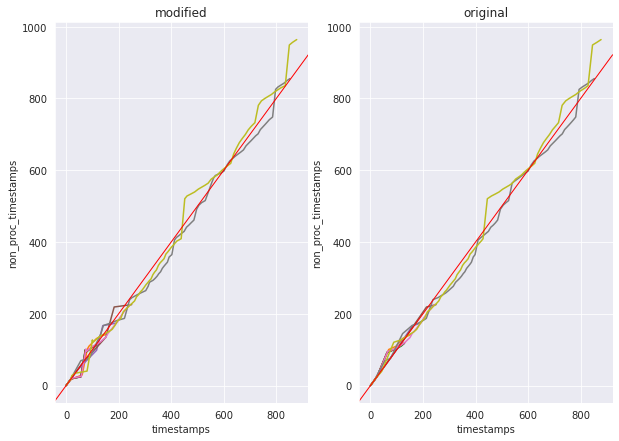

In [205]:
fig, axs = plt.subplots(1,2, figsize=(10,7))
sns.lineplot(data=pred_dfs, x="timestamps", y="non_proc_timestamps", hue="uuid",legend=None, ax=axs[0])
axs[0].axline((0, 0), (1, 1), linewidth=1, color='r')
axs[0].set_title('modified')
#axs.set_xlim(0,200)
#axs.set_ylim(0,200)

print('original')
sns.lineplot(data=all_df, x="timestamps", y="non_proc_timestamps", hue="uuid",legend=None, ax=axs[1])
axs[1].axline((0, 0), (1, 1), linewidth=1, color='r')
axs[1].set_title('original')
#axs.set_xlim(0,200)
#axs.set_ylim(0,200)

## Compare trial duration differences

original


Text(0.5, 1.0, 'original')

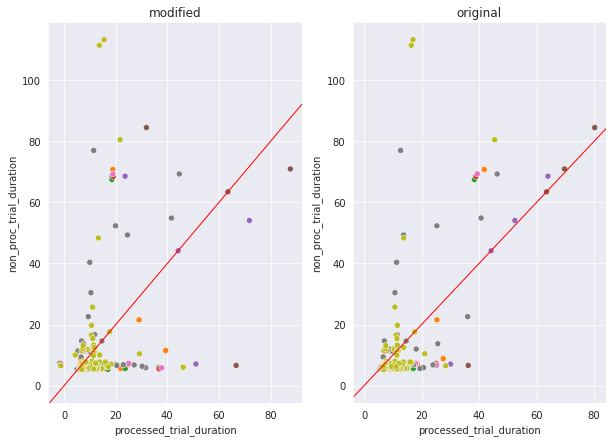

In [206]:
fig, axs = plt.subplots(1,2, figsize=(10,7))
sns.scatterplot(data=pred_dfs, x="processed_trial_duration", y="non_proc_trial_duration", hue="uuid",legend=None, ax=axs[0])
axs[0].axline((0, 0), (1, 1), linewidth=1, color='r')
axs[0].set_title('modified')
#axs.set_xlim(0,200)
#axs.set_ylim(0,200)

print('original')
sns.scatterplot(data=all_df, x="processed_trial_duration", y="non_proc_trial_duration", hue="uuid",legend=None, ax=axs[1])
axs[1].axline((0, 0), (1, 1), linewidth=1, color='r')
axs[1].set_title('original')
#axs.set_xlim(0,200)
#axs.set_ylim(0,200)

### Original trial durations

(0.0, 200.0)

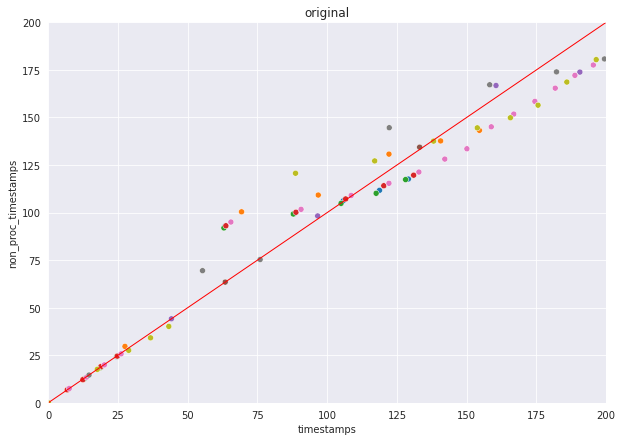

In [217]:
fig, axs = plt.subplots(figsize=(10,7))
sns.scatterplot(data=all_df, x="timestamps", y="non_proc_timestamps", hue="uuid",legend=None, ax=axs)
axs.axline((0, 0), (1, 1), linewidth=1, color='r')
axs.set_title('original')
axs.set_xlim(0,200)
axs.set_ylim(0,200)

## Association between measured trial duration and actual difference

Text(0.5, 1.0, 'original')

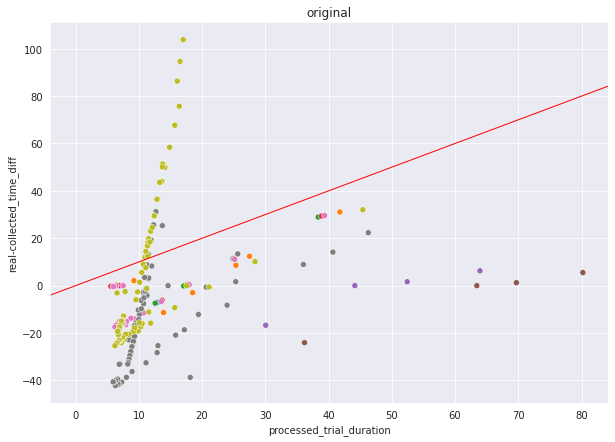

In [245]:
fig, axs = plt.subplots(figsize=(10,7))

sns.scatterplot(data=all_df, x="processed_trial_duration", y="real-collected_time_diff", hue="uuid",legend=None, ax=axs)
axs.axline((0, 0), (1, 1), linewidth=1, color='r')
axs.set_title('original')
#axs.set_xlim(5,15)
#axs.set_ylim(5,15)

In [462]:
all_windows_subs['fitted_adjustment'] = all_windows_subs.timestamps \
                            + tdur_model.params['timestamps']*all_windows_subs['timestamps'] \
                            + tdur_model.params['processed_trial_duration']*all_windows_subs['processed_trial_duration'] \
                            + tdur_model.params['processed_trial_duration_1']*all_windows_subs['processed_trial_duration_1'] \
                            + tdur_model.params['Intercept']

collected error 23.68343214667556


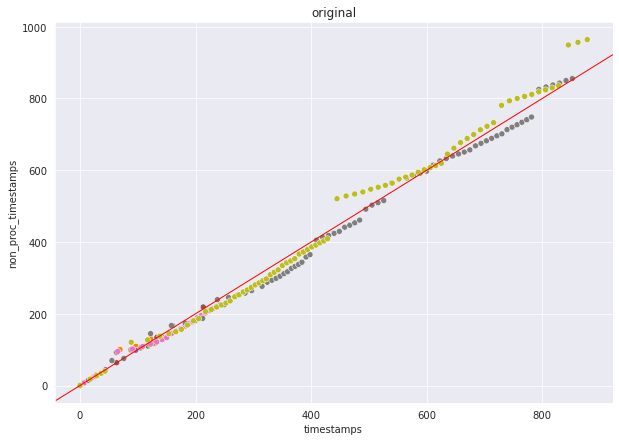

In [606]:
fig, axs = plt.subplots(figsize=(10,7))

sns.scatterplot(data=all_windows_subs, x="timestamps", y="non_proc_timestamps", hue="uuid",legend=None, ax=axs)
axs.axline((0, 0), (1, 1), linewidth=1, color='r')
axs.set_title('original')
#axs.set_xlim(0,200)
#axs.set_ylim(0,200)
print('collected error', np.sqrt(np.mean((all_windows_subs.timestamps-all_windows_subs.non_proc_timestamps)**2)))

adjusted error 28.703652251950512


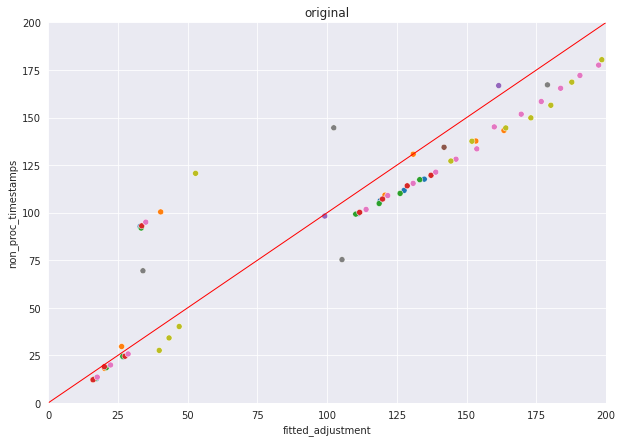

In [464]:
fig, axs = plt.subplots(figsize=(10,7))

sns.scatterplot(data=all_windows_subs, x="fitted_adjustment", y="non_proc_timestamps", hue="uuid",legend=None, ax=axs)
axs.axline((0, 0), (1, 1), linewidth=1, color='r')
axs.set_title('original')
axs.set_xlim(0,200)
axs.set_ylim(0,200)
print('adjusted error', np.sqrt(np.mean((all_windows_subs.fitted_adjustment-all_windows_subs.non_proc_timestamps)**2)))

## Describe

In [106]:
# fit our model with .fit() and show results
# we use statsmodels' formula API to invoke the syntax below,
# where we write out the formula using ~
# summarize our model
model_summary = model.summary()

# convert our table to HTML and add colors to headers for explanatory purposes
HTML(
(model_summary
    .as_html()
    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>'))
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

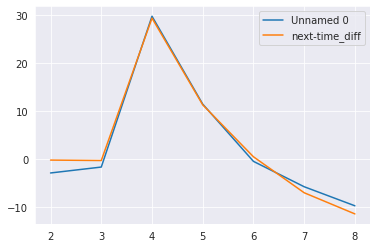

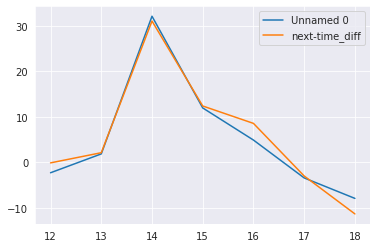

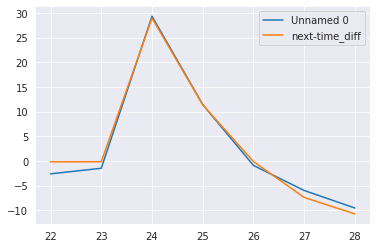

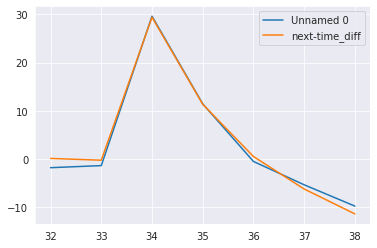

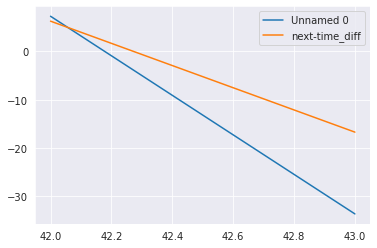

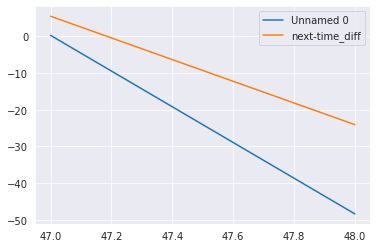

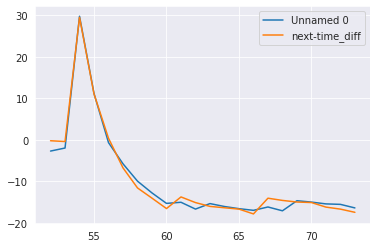

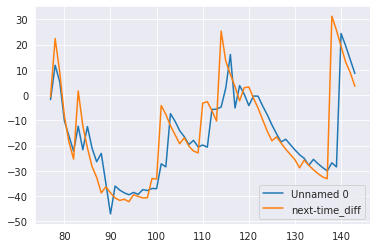

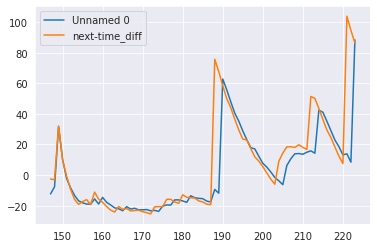

In [9]:
for r in runs:
    X,y = get_x_y(r)
    pred_df = pd.DataFrame([model.predict(X), y]).T
    pred_df.plot()

In [4]:
for run in runs:
  data = all_df.loc[all_df.uuid == run, ['processed_trial_duration', 'diff']]
  model = VAR(data)
  results = model.fit(2)
  print('---------------------------------------------------')
  print(run)
  print(results.summary())

---------------------------------------------------
6ca88a26-30b6-4ade-aa3b-5badf384f250
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Nov, 2022
Time:                     23:29:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.29055
Nobs:                     7.00000    HQIC:                   2.41277
Log likelihood:          -21.6525    FPE:                    59.9913
AIC:                      3.36782    Det(Omega_mle):         20.4137
--------------------------------------------------------------------
Results for equation processed_trial_duration
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              42.238048        37.400591            1.129        

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, f

In [ ]:
results.plot()


In [74]:
lag_order = results.k_ar
results.forecast(data.values[-lag_order:], 5)

array([[-32.71409044, -66.83581893],
       [-41.14634807, -56.11304038],
       [-31.40830595, -30.61544512],
       [ 19.62998712,  27.89045481],
       [ 45.11145439,  50.99734738]])

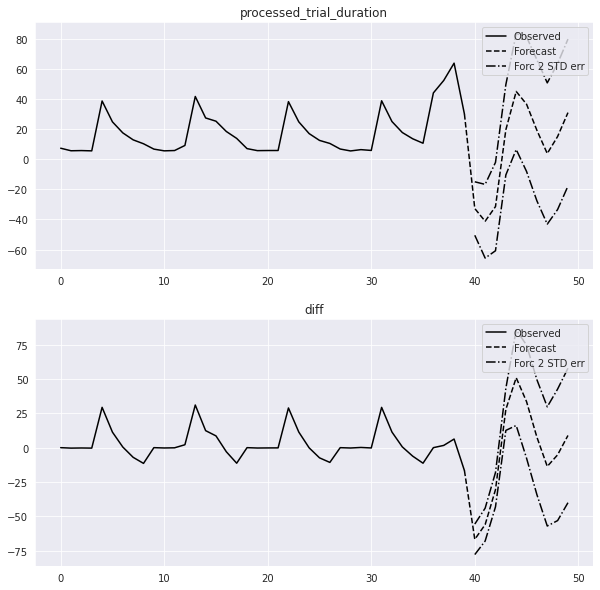

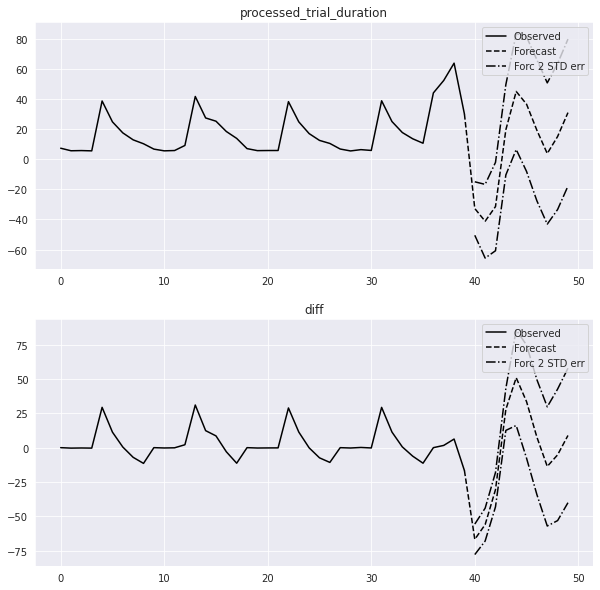

In [75]:
results.plot_forecast(10)
